In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import pairwise_distances
import jax.numpy as jnp

from skscope import ScopeSolver
# from sklearn.cluster import SpectralClustering
from itertools import permutations

Exemplar-based clustering
-----------------------------

### Mixture models
We consider the examplar-based clustering problem [[1]](#refer-1), which is one of the most basic problems of unsupervised learning with applications in a wide
variety of fields.

Given a set of $n$ data ponits $\mathcal{X}=\{x_1,\cdots,x_n\}\subset\mathbb{R}^d$, we want to divide these points into $K$ clusters.

We use the mixture-model type clustering methods, specifically, we assume that these points are generated from $K$ mixture distributions $\{f(x;m_j)\}_{j=1}^K$ where $f(x;m_j)$ is an exponential family distribution and $m_j$ denotes the position parameter. Hence, the clustering problem aims at maximizing the following log-likelihood function:
$$\max_{q, m}l(q,m;\mathcal{X})=\frac{1}{n}\sum_{i=1}^n\log\left[\sum_{j=1}^Kq_jf(x_i;m_j)\right]$$
where $\{q_j\}_{j=1}^K$ are mixture ratios and satisfy $\sum_jq_j=1, q_j\geq 0$ and the mixture distribution is of the exponential form $f(x;m_j)=C(x)\exp(-d_{\phi}(x,m_j))$. Here, $d_{\phi}(\cdot,\cdot)$ is some Bregman divergence and it reduces to normal distribution when $d_{\phi}$ is the Euclidean distance.

Note that, due to the existence of $q$, this optimization problem is non-convex and thus difficult to solve.

### Exemplar approximation

Suppose that each cluster $j\in [K]$ has many enough observations, then we can approximate each unknown position parameter $m_j$ by one of the data point $x_i$ (still unknown).

That is, the optimization over $K$ position parameters is reduced to the selection of $K$ data points which is the so called variable selection or sparse optimization problem.

Specifically, we can reformulate the clustering problem as the following constrained sparse optimization:
$$\max_{q}l(q;\mathcal{X})=\frac{1}{n}\sum_{i=1}^n\log\left[\sum_{j=1}^n q_jf(x_i;x_j)\right], \text{ s.t. } \|q\|_0=K, \sum_jq_j=1, q_j\geq 0.$$
However, it still can not be solved directly due to the simplex constraint.

To remove the simplex constraint, we use a re-parametrization trick and solve the following unconstrained sparse optimization problem:
$$\min_{q}-l(q;\mathcal{X})=-\frac{1}{n}\sum_{i=1}^n\log\left[\sum_{j=1}^n \frac{|q_j|}{\|q\|_1}f(x_i;x_j)\right], \text{ s.t. } \|q\|_0=K.$$
Therefore, we can cluster $\mathcal{X}$ using ``skscope`` by simply writting the above re-parametrized loss function with ``jax.numpy``. 

### Synthetic data
In the following example, we generate a synthetic dataset from a $d=2$ dimensional Gaussian mixture model with $K=5$ miture components.

The mean of each component is generated from a $d=2$ dimensional standard normal distribution and the corresponding covariance matrix is diagonal.

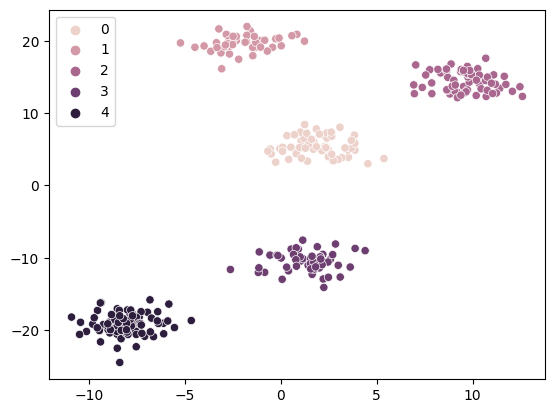

In [2]:
rng = np.random.default_rng(0)

d, K, n = 2, 5, 300
mu = rng.standard_normal((d, K)) * 15
Sigma = np.eye(d) * 2
labels = rng.choice(np.arange(K), p=[1/K]*K, size=n)

X = np.zeros((n, d))
for i in range(n):
    X[i] = rng.multivariate_normal(mu[:, labels[i]], Sigma)

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels)
plt.show()

The following code shows a specified implementation of clustering method via ``skscope``:

- Here, we choose $d_{\phi}$ to be the Euclidean distance and set the scaled parameter ``beta``$=0.5$,
- We use a small quantity ``eps`` to avoid numerical issues: zero division or taking the logarithm of a negative number,
- The ``sparsity`` parameter is set to be the true number of clusters, $K$ (here, we do not consider the estimation of $K$ if it is unknown).

In [3]:
beta = 0.5
D = pairwise_distances(X)  # distance matrix

init_params = rng.standard_normal(n)
def clustering_loss(params):
    eps = 1e-7
    params = jnp.abs(params) / (jnp.linalg.norm(params, ord=1) + eps)
    loss = - jnp.mean(jnp.log(jnp.exp(- beta * D) @ params + eps))
    return loss

solver = ScopeSolver(n, sparsity=K)
params = solver.solve(clustering_loss, init_params=init_params)
support = np.nonzero(params)[0]
mu_hat = X[support]
print('Selected data points as cluster positions: ', support)

Selected data points as cluster positions:  [  1  65 129 209 227]


After $K=5$ positions are selected. we can divide $\mathcal{X}$ into $K$ clusters by assigning each data point to the nearest position.

Note that, the permutation of the cluster labels will not affect the true performance of our method. 

Thus, we use the following ``permutate`` function to relabel the estimated cluster labels and compute the corresponding accuracy.

In [4]:
labels_hat = np.zeros(n)
for i in range(n):
    labels_hat[i] = np.argmin(np.sum((X[i] - mu_hat) ** 2, axis=1))

def permutate(labels_hat, labels):
    a = np.unique(labels_hat).astype(int)
    labels_best = labels.copy()
    acc_best = 0
    for perm in set(permutations(a)):
        perm_dict = {i: perm[i] for i in range(len(perm))}
        labels_tmp = np.array([perm_dict[i] for i in labels_hat])
        acc = np.sum(labels_tmp == labels) / n
        if acc > acc_best:
            acc_best = acc
            labels_best = labels_tmp
    print('Accuracy:', acc_best)
    return labels_best

labels_hat = permutate(labels_hat, labels)

Accuracy: 1.0


The clustering performance can also be evaluated by the following figure.
- the left subplot shows the original data points and the clusters,
- the central subplot shows the estimated cluster positions,
- the right subplot shows the estimated clusters of ``skscope``.
  
This plot shows that we correctly cluster each data point into its corresponding cluster.

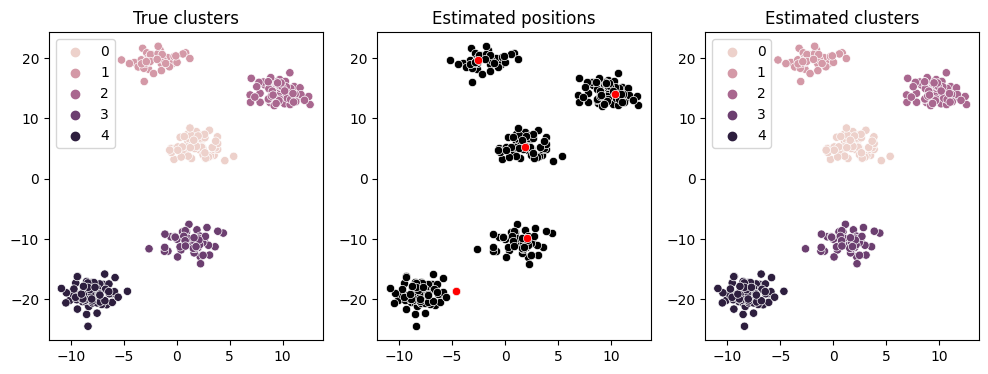

In [5]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 4))

sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, ax=ax1)
sns.scatterplot(x=X[:, 0], y=X[:, 1], color='k', ax=ax2)
sns.scatterplot(x=mu_hat[:, 0], y=mu_hat[:, 1], color='r', ax=ax2)
sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels_hat, ax=ax3)
ax1.set_title('True clusters')
ax2.set_title('Estimated positions')
ax3.set_title('Estimated clusters')

plt.show()

### Reference

<div id="refer-1"></div>

- [1] Lashkari, D., & Golland, P. (2007). Convex clustering with exemplar-based models. Advances in neural information processing systems, 20.